#Parametrage

MODULE DE TEST POUR EVOLUTION DE LA FONCTION DE CAREPATH PLOT

1- TEST D'UN PLOT JUSTE AVEC 1 CLUSTERING (PARCOURS ou TIME CLUST)
2- TEST DU FILTRE D'AFFICHAGE EN ACCORD AVEC LE PARAMETRE (Traitement + Rdth seule + Chir seule + Chimio seule)
3- Verification du calcul de l'abcisse avec le subclustering (un décalage semble exister entre le plot des parcours et le postionnement des verticales)


MEMO : 
AJOUTER DANS LE LOG MLFLOW LES PARAMETRES DE CLUSTERING :
Name, Méthod, linkage, Nb_cluster, Threshold, Table Name + (Dist method, WindowType, WindowSize)

AJOUTER DANS LE LOG MLFLOW LES PARAMETRES DE CPP PLOT: 
CPP Order, Save Table, Filter, df_value

Prévoir 3 types de carepath plot dans le run :
- Carepath plot juste de la variable filtrée (Radiothérapie, Chirurgie, OncoMed, etc...)
- Carepath plot des types de variable filtrées (Type traitement uniquement)
- Carepath plot de l'ensemble du parcours toutes dimensions confondues.


In [1]:
from datetime import datetime

#import pyodbc
import sqlalchemy
#import sqlalchemy as msql
#import Connexion_bdd as Cx_bdd
import numpy as np
import pandas as pd
import Requetes_SQL as Req_SQL
import matplotlib.pyplot as plt
import seaborn as sns
#import dtw as dtw
#import tsfresh #TimeSeries Transformation library
import my_custom_func_TS_Clust_1 as Mcftsc
import my_custom_func_Clustering as McfC
import my_custom_func_Carepath_plotting as Mcfcp
import my_custom_func_config as Mcfconf
import my_custom_func_batch_follow as Mcfbf
import mlflow

from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics, tree
import Sql_Alchemy_Classes as AlSQL

2024-01-04 22:41:40,860 INFO sqlalchemy.engine.Engine SELECT CAST(SERVERPROPERTY('ProductVersion') AS VARCHAR)
2024-01-04 22:41:40,860 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-01-04 22:41:40,862 INFO sqlalchemy.engine.Engine SELECT schema_name()
2024-01-04 22:41:40,862 INFO sqlalchemy.engine.Engine [generated in 0.00047s] ()
2024-01-04 22:41:40,864 INFO sqlalchemy.engine.Engine SELECT CAST('test max support' AS NVARCHAR(max))
2024-01-04 22:41:40,864 INFO sqlalchemy.engine.Engine [generated in 0.00038s] ()
2024-01-04 22:41:40,866 INFO sqlalchemy.engine.Engine SELECT TOP (10) [idUFX_Ress_Equ] FROM [ICO_Activite].[dbo].[Listing_UF_V3]
2024-01-04 22:41:40,866 INFO sqlalchemy.engine.Engine [raw sql] ()
Connexion BDD - OK


##GET TABLES

In [2]:
#GET Variables

#df_Actes_graph
Requete="""SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  --WHERE Table_Cluster.NIP = Table_Acte.NIP"""
df_Actes_graph=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

#Aggreg_Parcours_clust
#-> get clust name and query BDD to get the table NIP-Cluster

#Requete2="""SELECT *
#  FROM [ICO_Activite].[dbo].[Tmp_Cl_P1]
#"""
#df_Parcours_clust=AlSQL.AlSQL_Requete(AlSQL.engine,Requete2,'No')


#Aggreg_Time_clust
#-> get here the clustname
Parcours_clust_par='Cl_P1'

#AC_Config (Myorder, Table_name, Requete,Filter_df_col, Filter_df_value)

#Open config.csv file as a dict
file_path = "C:\\Users\\vince\\Documents\\DSTI\\DSTI_Projects\\ML ICO Activity\\07-Batch_configuration\\export_config.csv"
#file_path = file_path.replace('\\\\', '\\')

config = pd.read_csv(file_path, encoding='ISO-8859-1')
#Add a function to chekc csv file
#print(Mcfbf.myprint('Import csv batch file succeed', 1, 1))

Ac_config = config.iloc[0]

2024-01-04 22:41:40,885 INFO sqlalchemy.engine.Engine SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  --WHERE Table_Cluster.NIP = Table_Acte.NIP
2024-01-04 22:41:40,886 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


In [3]:
My_order=Ac_config['CPP_Order']
Table_name=Ac_config['CPP_Save_Tble_Name']
Requete=Ac_config['CPP_Requete']
Filter_df_col=Ac_config['CPP_Filter_df_col']
Filter_df_value=Ac_config['CPP_Filter_df_value']
myouputpath=Ac_config['myouputpath']

In [4]:
#PREPARE THE DATASET TO BE PLOTED
CPP_Param=Mcfconf.set_CPP_Plot_parameters(Ac_config)

myRequete="""SELECT * FROM [ICO_Activite].[dbo].[""" + CPP_Param['primary_clust_TableName'] + """]"""
cluster1_Table=AlSQL.AlSQL_Requete(AlSQL.engine,myRequete,'No')

myRequete="""SELECT * FROM [ICO_Activite].[dbo].[""" + CPP_Param['sub_clust_TableName'] + """]"""
cluster2_Table=AlSQL.AlSQL_Requete(AlSQL.engine,myRequete,'No')

My_order= CPP_Param['CPP_order']


Parcours_DF=Mcfcp.Prepare_Plot_carepath_twice_clustered(df_Actes_graph,cluster1_Table,cluster2_Table,CPP_Param)
Abcisses_DF, Plot_dict =Mcfcp.Compute_abcisses_two_clusters(Parcours_DF,CPP_Param)
print('CPP - Computing Abcisses OK')


#SAVE THE CLUSTERING + PLOTTING VALUES TO THE DATABASE
Mcfcp.Save_Cluster_and_Carepath_to_Database_twice_clustered(Abcisses_DF,CPP_Param['primary_clust_name'],CPP_Param['sub_clust_name'],myouputpath,CPP_Param['CPP_Table_Name'])
print(Mcfbf.myprint('CPP - Saving Abcisses to BDD OK', 1, 1))

#GET A DATASET OF ACTES

Requete="""SELECT Table_Acte.[NIP]  ,
            Table_Cluster.""" + CPP_Param['primary_clust_name'] + """ as Clust1  ,
            Table_Cluster.""" + CPP_Param['sub_clust_name'] + """ as Clust2  ,
            Table_Cluster.X_abscisse     ,
            Table_Acte.[J_Parcours_V1]      ,
            Table_Acte.[J_Parcours_V3]     ,
            Table_Acte.[Service]      ,
            Table_Acte.[Activite]      ,
            Table_Acte.[Phase]     ,
            Table_Acte.[Dimension]      ,
            Table_Acte.[Type_seq]  

            FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte ,
            [ICO_Activite].[dbo].[""" + CPP_Param['CPP_Table_Name'] + """] as Table_Cluster

            WHERE Table_Cluster.NIP = Table_Acte.NIP  

            ORDER BY Table_Acte.[J_Parcours_V1] desc, Table_Acte.[NIP]"""
#Clust1 asc ,Clust2 asc,

df_Actes_graph2=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')
#FILTER THE DATASET IN ORDER NOT TO SHOW ALL ACTES
filtered_df = df_Actes_graph2[df_Actes_graph2[CPP_Param['CPP_Filter_df_col']] == CPP_Param['CPP_Filter_df_value']]
nip_no_treatment_info = df_Actes_graph2[~df_Actes_graph2['NIP'].isin(filtered_df['NIP'])]
nip_no_treatment_info = nip_no_treatment_info[['NIP', 'X_abscisse']].drop_duplicates()
#nip_no_treatment_info = nip_no_treatment_info[['NIP', 'Clust1','Clust2', 'X_abscisse']].drop_duplicates()
final_df = pd.concat([filtered_df, nip_no_treatment_info], ignore_index=True)
final_df_sorted = final_df.sort_values(by='X_abscisse')

#PLOT AND SAVE IN MLFLOW
Mcfcp.plot_df_actes_twice_clustered(final_df_sorted,Parcours_DF,CPP_Param['primary_clust_name'],CPP_Param['sub_clust_name'],Plot_dict,mlflow,myouputpath,'Plots')
#Mcfcp.plot_df_actes_one_clust(final_df_sorted,Aggreg_Parcours_clust,Parcours_Clust_parameters,Aggreg_Time_clust,Time_Clust_parameters, Plot_dict, mlflow, myouputpath)
print(Mcfbf.myprint('CPP - PLOTING AND SAVE TO MLFLOW OK', 1, 1))

2024-01-04 22:41:41,369 INFO sqlalchemy.engine.Engine SELECT * FROM [ICO_Activite].[dbo].[Mlflow_Exp_NIP_Cl_P1]
2024-01-04 22:41:41,370 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK
2024-01-04 22:41:41,572 INFO sqlalchemy.engine.Engine SELECT * FROM [ICO_Activite].[dbo].[Mlflow_Exp_NIP_Cl_T1]
2024-01-04 22:41:41,572 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK
CPP - Computing Abcisses OK
2024-01-04 22:41:41,677 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-01-04 22:41:41,678 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Mlflow_Exp_NIP_CPP1
2024-01-04 22:41:41,679 INFO sqlalchemy.engine.Engine [generated in 0.00063s] ()
2024-01-04 22:41:41,681 INFO sqlalchemy.engine.Engine COMMIT
2024-01-04 22:41:41,686 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME], [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR

In [5]:
#Get df_parcours from database
CPP_Param=Mcfconf.set_CPP_Plot_parameters(Ac_config)

myRequete="""SELECT * FROM [ICO_Activite].[dbo].[""" + CPP_Param['primary_clust_TableName'] + """]"""
cluster1_Table=AlSQL.AlSQL_Requete(AlSQL.engine,myRequete,'No')
myRequete="""SELECT * FROM [ICO_Activite].[dbo].[""" + CPP_Param['sub_clust_TableName'] + """]"""
cluster2_Table=AlSQL.AlSQL_Requete(AlSQL.engine,myRequete,'No')

Requete="""SELECT Table_Acte.[NIP]  ,
            Table_Cluster.""" + CPP_Param['primary_clust_name'] + """ as Clust1  ,
            Table_Cluster.""" + CPP_Param['sub_clust_name'] + """ as Clust2  ,
            Table_Cluster.X_abscisse     ,
            Table_Acte.[J_Parcours_V1]      ,
            Table_Acte.[J_Parcours_V3]     ,
            Table_Acte.[Service]      ,
            Table_Acte.[Activite]      ,
            Table_Acte.[Phase]     ,
            Table_Acte.[Dimension]      ,
            Table_Acte.[Type_seq]  

            FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte ,
            [ICO_Activite].[dbo].[""" + CPP_Param['CPP_Table_Name'] + """] as Table_Cluster

            WHERE Table_Cluster.NIP = Table_Acte.NIP  

            ORDER BY Table_Acte.[J_Parcours_V1] desc, Table_Acte.[NIP]"""



Mcfcp.Prepare_Save_Plot_twice_clustered(df_Actes_graph,cluster1_Table,cluster2_Table,CPP_Param,Requete,myouputpath,mlflow,'Plots')
print(Mcfbf.myprint('Subclust CPP - Plotting and Saving OK', 1, 1))

2024-01-04 22:41:43,372 INFO sqlalchemy.engine.Engine SELECT * FROM [ICO_Activite].[dbo].[Mlflow_Exp_NIP_Cl_P1]
2024-01-04 22:41:43,373 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK
2024-01-04 22:41:43,506 INFO sqlalchemy.engine.Engine SELECT * FROM [ICO_Activite].[dbo].[Mlflow_Exp_NIP_Cl_T1]
2024-01-04 22:41:43,507 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK
CPP - Computing Abcisses OK
2024-01-04 22:41:43,608 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-01-04 22:41:43,609 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Mlflow_Exp_NIP_CPP1
2024-01-04 22:41:43,610 INFO sqlalchemy.engine.Engine [cached since 1.932s ago] ()
2024-01-04 22:41:43,612 INFO sqlalchemy.engine.Engine COMMIT
2024-01-04 22:41:43,615 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME], [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCH

2024-01-04 22:41:45,105 INFO sqlalchemy.engine.Engine SELECT * FROM [ICO_Activite].[dbo].[Mlflow_Exp_NIP_Cl_P1]
2024-01-04 22:41:45,106 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK
2024-01-04 22:41:45,307 INFO sqlalchemy.engine.Engine SELECT * FROM [ICO_Activite].[dbo].[Mlflow_Exp_NIP_Cl_P2]
2024-01-04 22:41:45,307 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK
2024-01-04 22:41:45,441 INFO sqlalchemy.engine.Engine SELECT * FROM [ICO_Activite].[dbo].[Mlflow_Exp_NIP_Cl_P3]
2024-01-04 22:41:45,441 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK
2024-01-04 22:41:45,675 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-01-04 22:41:45,677 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Mlflow_Exp_NIP_FPP1
2024-01-04 22:41:45,677 INFO sqlalchemy.engine.Engine [generated in 0.00073s] ()
2024-01-04 22:41:45,681 INFO sqlalchemy.engine.Engine COMMIT
2024-01-04 22:41:45,684 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[T

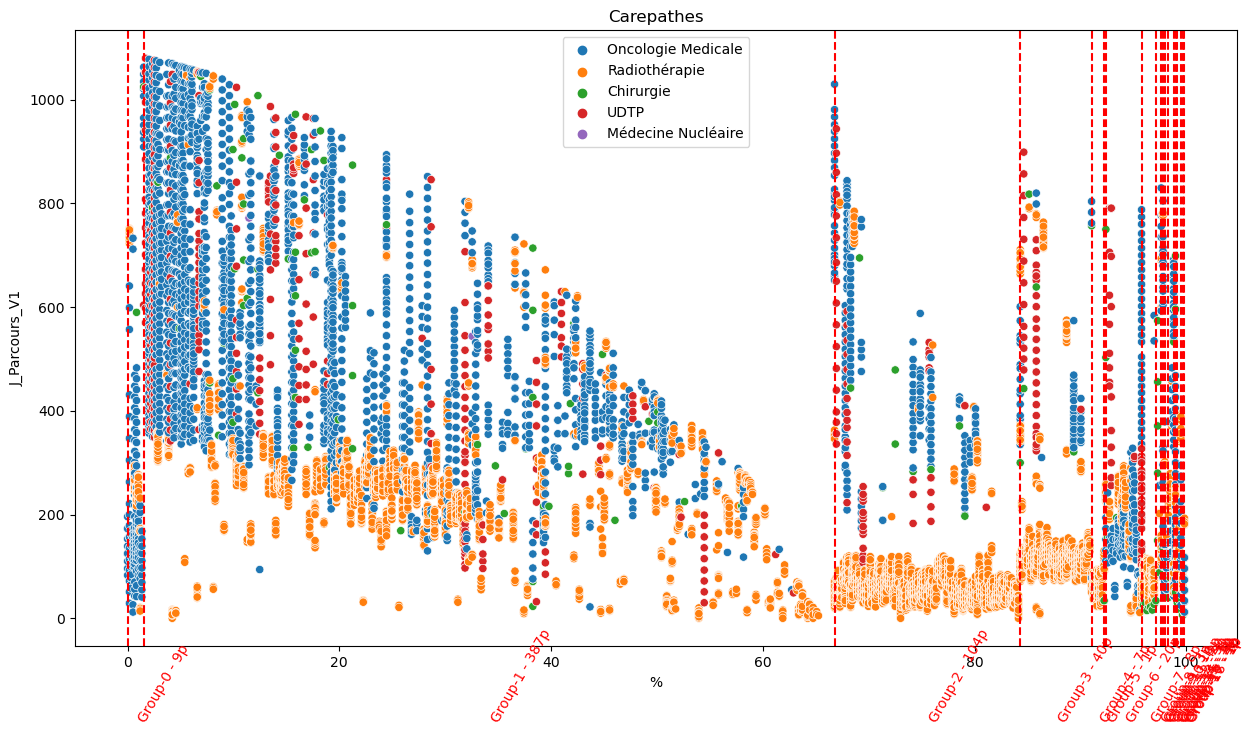

**************   CPP - PLOTING AND SAVE TO MLFLOW OK Batch 2/1**************
**************   Subclust CPP - Plotting and Saving OK Batch 2/1**************


In [6]:
#Get df_parcours from database
FPP_Param=Mcfconf.set_FPP_Plot_parameters(Ac_config)
FPP_Param

nameToBeSaved=FPP_Param['FPP_Name']

tables_list =[]
cluster_names= []

if FPP_Param['clust1TableName']!='NO_VALUE':
    #Get Parcours Clusterings
    myRequete="""SELECT * FROM [ICO_Activite].[dbo].[""" + FPP_Param['clust1TableName'] + """]"""
    cluster1_Table=AlSQL.AlSQL_Requete(AlSQL.engine,myRequete,'No')
    tables_list.append(cluster1_Table)
    cluster_names.append(FPP_Param['clust1Name'])

if FPP_Param['clust2TableName']!='NO_VALUE':
    myRequete="""SELECT * FROM [ICO_Activite].[dbo].[""" + FPP_Param['clust2TableName'] + """]"""
    cluster2_Table=AlSQL.AlSQL_Requete(AlSQL.engine,myRequete,'No')
    tables_list.append(cluster2_Table)
    cluster_names.append(FPP_Param['clust2Name'])

if FPP_Param['clust3TableName']!='NO_VALUE':    
    myRequete="""SELECT * FROM [ICO_Activite].[dbo].[""" + FPP_Param['clust3TableName'] + """]"""
    cluster3_Table=AlSQL.AlSQL_Requete(AlSQL.engine,myRequete,'No')
    tables_list.append(cluster3_Table)
    cluster_names.append(FPP_Param['clust3Name'])

# Call the function to merge the tables
result_table = Mcfcp.FPP_merge_tables(tables_list, 'NIP', cluster_names)

#Sauvegarder dans la BDD la nouvelle table - Cluster
Table_Cluster=FPP_Param['FPP_Table_Name']
Requete = 'EXECUTE dbo.Delete_Table_if_exists ' + Table_Cluster
with AlSQL.engine.begin() as conn:
            conn.execute(sqlalchemy.text(Requete))
#my_df[['NIP',principal_clust_name]].to_sql(Table_Cluster,AlSQL.engine)
result_table.to_sql(Table_Cluster,AlSQL.engine)

Requete="""SELECT Table_Acte.[NIP]  ,
            Table_Cluster.""" + 'Concat_' + FPP_Param['clust1Name'] + """ as Clust  ,

            Table_Cluster.X_abscisse     ,
            Table_Acte.[J_Parcours_V1]      ,
            Table_Acte.[J_Parcours_V3]     ,
            Table_Acte.[Service]      ,
            Table_Acte.[Activite]      ,
            Table_Acte.[Phase]     ,
            Table_Acte.[Dimension]      ,
            Table_Acte.[Type_seq]  

            FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte ,
            [ICO_Activite].[dbo].[""" + FPP_Param['FPP_Table_Name'] + """] as Table_Cluster

            WHERE Table_Cluster.NIP = Table_Acte.NIP  

            ORDER BY Table_Acte.[J_Parcours_V1] desc, Table_Acte.[NIP]"""

Filter_df_col=FPP_Param['FPP_Filter_df_col']
Filter_df_value=FPP_Param['FPP_Filter_df_value']
clustname='Concat_' + FPP_Param['clust1Name']

Mcfcp.Prepare_Save_Plot_one_clust(df_Actes_graph,result_table,clustname,FPP_Param['FPP_order'],myouputpath,FPP_Param['FPP_Table_Name'],Requete,Filter_df_col,Filter_df_value,mlflow,nameToBeSaved)
print(Mcfbf.myprint('Subclust CPP - Plotting and Saving OK', 1, 1))

In [ ]:
#Merge all tables to create a new clustering result of parcours

#Compute the average individual of each new cluster (for each dimension (1 dim = 1Table))  NEXT

#Compute the mean individual of each new cluster (for each dimension (1 dim = 1Table)) NEXT

#Create and save the new Parcours cluster



#Get Time Clusterings (optional subclust)

#Merge all tables to create a new clustering result of time

#Compute the average individual of each new cluster (1 by dimension = nb of tables)

#Compute the mean individual of each new cluster

#Create and save the new Time cluster


#Plot the TS_Curves
